In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.utility_functions as ut
import resources.abundance_classes as ac
import resources.chart_kwargs as ck

import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex


# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

a_fail_rate = 50

unit_label = 'pcs_m'

# name of the output folder:
name_of_project = 'bassin_report_all'

a_color = 'dodgerblue'

# set the maps
bassin_map = PILImage.open("resources/maps/survey_locations_all.jpeg")
bassin_pallette = {'rhone':'dimgray', 'aare':'salmon', 'linth':'tan', 'ticino':'steelblue', 'reuss':'purple'}

# define the feature level and components
comps = ['linth', 'rhone', 'aare', 'ticino']
comp_labels = {"linth":"Linth/Limmat", "rhone":"Rhône", 'aare':"Aare", "ticino":"Ticino/Cerisio", "reuss":"Reuss"}
comp_palette = {"Linth/Limmat":"dimgray", "Rhône":"tan", "Aare":"salmon", "Ticino/Cerisio":"steelblue", "Reuss":"purple"}

# explanatory variables:
luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']

# columns needed
use_these_cols = ['loc_date' ,
                  '% to buildings',
                  '% to trans', 
                  '% to recreation',
                  '% to agg',
                  '% to woods',
                  'population',
                  'river_bassin',
                  'water_name_slug',
                  'streets km',
                  'intersects',
                  'length',
                  'groupname',
                  'code'
                 ]

# these are default
top_name = ["All survey areas"]

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# get your data:
survey_data = pd.read_csv('resources/results_with_land_use_2015.csv')
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/dims_data.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# map water_name_slug to water_name
wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True).drop_duplicates()
wname_wname.set_index('water_name_slug', inplace=True)
        
def make_plot_with_spearmans(data, ax, n):
    """Gets Spearmans ranked correlation and make A/B scatter plot. Must proived a
    matplotlib axis object.
    """    
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    
    return ax, corr, a_p

dfCodes.set_index("code", inplace=True)

# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation: includes spray foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/tampons, applicators"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)
dfCodes = sut.shorten_the_value(["G82", "description", "Expanded foams 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G81", "description", "Expanded foams .5cm - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G117", "description", "Expanded foams < 5mm"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

# Transport: an empirical approach

The hydrologic conditions of rivers have an effect on the distance and direction that an object will travel. Large low density objects will most likely be transported to the next reservoir or area of reduced flow. Once in the area of reduced flow surface currents and wind will transport low density objects untill they degrade and sink or land on the shore, a few may make it to the next reservoir. High density objects will only be transported if the flow velocity and turbulence of the water are sufficient to keep the objects off the bottom. Once high density items enter a low velocity zone they tend to settle or sink. {cite}`Kooi2018`

This has implications in the modeling and understanding of the fate of plastics long before they enter the ocean. Identifying accumulation areas of specific type of objects and the conditions that contribute or do not to the accumulation of those objects is part of understanding the environmental framework that those products are used in. This concerns fields such as waste management or product design. {cite}`Schwarz`

Beach litter surveys are collections of many individual surveys. Here we compare the results of two different groups of items. In one group the use case is well known and there are many studies linking the object to human behavior. The other group includes fragmented objects of different densities, specific objects less than 5mm and construction plastics. __If the transport mechanism (any aquatic discharge) is the reason that the object is found at the beach then the land use profile will have little effect on the accumualtion of that object__.

## The test groups

The most common objects  with respect to the results of the test for association completed in section 2.2.4.1 were compared under two different or opposing land use profiles. The most common objects seperated first in two groups according to the following land use associations: 

1. __contributed:__ Objects that have multiple positive associations to land use features and one association is to buildings
   
   * food and drink (FD)
     * cigarette ends
     * snack wrappers
   
2. __distributed:__ Objects that have few or no postive associations to land use features

   * fragmented plastics (FP)
     * fragmented plastics
     * plastic construction waste
     
Two objects were selected from each group. Fragmented plastics and plastic constuction waste were chosen from the distributed group because there is a higher proportion of high density plastics in these two groups.

The survey locations were grouped into two classess:

1. __urban:__ Locations that have a percent of land attributed to buildings GREATER than the median
2. __rural:__ Locations that have a percent of land attributed to buildings LESS than the median AND percent of land attributed to woods or agriculture greater than the median

The rural class had 142 surveys for 47 locations versus 158 surveys from 37 locations in the urban class.

## The test

If an object is transported to a survey location due to hydrologic conditions then elevated survey results for the object under consideration will not be associated with the land use profile of the location(s) under consideration. We can test for the opposite case by using objects that have known associations
with land use or behavior.

## The survey environment


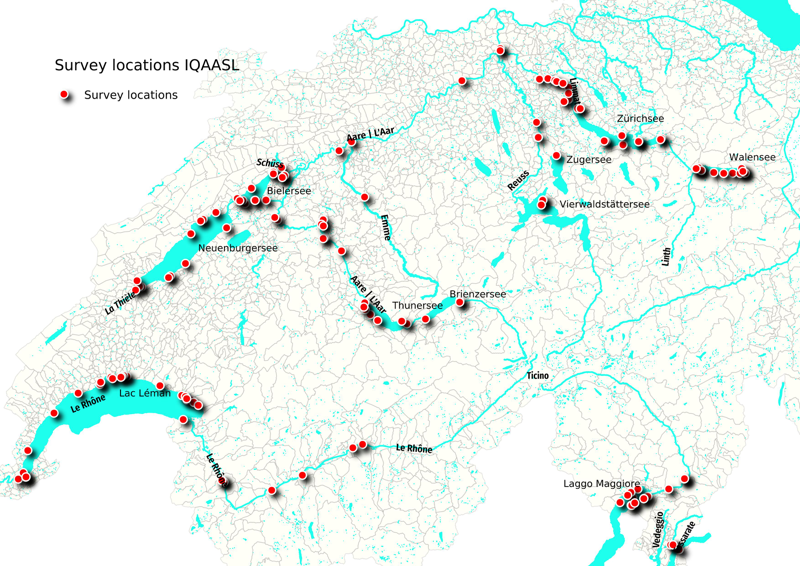

In [2]:
output = io.BytesIO()
bassin_map.thumbnail((800, 1200))
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

The differences in land use, and the density of that use have definite implications in regards to conducting litter-surveys and interpreting the results. In urban zones or regional agglomerations the land has been developed right up to the shoreline. In these areas there are a certain number of public beaches that are adequate for sampling, but the conditions on public beaches are not representative of the shoreline conditions. The majority of accesible shoreline is small strips of land between the lake or river and the structure used to contain it. 

Surveying in agricultural zones or woodlands presents the same challenges with different variables. Land that is used for agricultural purposes is exploited as close to the water front as is feasible to safely operate modern equipment. Long stretches of lake shore are bordered on one side by railways or lake shore roads that further reduce the access and width of survey locations. The space that is left between these different zones and the waters edge is usually occupied by a foot path or some kind of access road. If the survey is on a river then the path or access road is usually on a levee and the survey area consists of space between the base of the levee and the waters edge, this space reduces to zero for weeks at a time on many swiss rivers.

### Choosing survey sites

The survey locations were chosen based on the following criteria:

1. Data from previous surveys (SLR, MCBP)
2. Year round safe access
3. Within 30 minutes walking distance from nearest public transport

#### Sampling frequency and locations

Intitially at least two regions on each lake were designated to recieve monthly samples:

1. A location with public access closest to the primary river source
2. A location with public access closest to the primary river drainage

With these two locations as anchor points, other locations were selected randomly in between the discharge areas and the drainage areas of each lake. With the intention of connecting the two anchor points by collecting samples from different locations between them. In total 385 litter-surveys were conducted within the four survey areas touching 77 municipalities with a combined population of 1,735,000.

In [3]:
a_data = survey_data.copy()
a_dated = a_data[(a_data.date >= start_date)&(a_data.date <= end_date)].copy()

# format columns and slice by date
a_data['loc_date']=tuple(zip(a_data.location, a_data.date))
a_data['date']=pd.to_datetime(a_data['date'], format='%Y-%m-%d')
a_data = a_data[(a_data.date >= start_date)&(a_data.date <= end_date)]

# combine lugano and maggiore
a_data['river_bassin'] = a_data.river_bassin.where(a_data.river_bassin != 'tresa', 'ticino' )

# combine reuss and linth
a_data['river_bassin'] = a_data.river_bassin.where(a_data.river_bassin != 'reuss', 'linth' )

# convert meters of streets to kilometers
a_data['streets'] = a_data.streets.astype('int')
a_data['streets km'] = a_data.streets/1000

# make a p/50m column, keep the pcs_m column
a_data['p/50m'] = (a_data.pcs_m *50).astype('int')

# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams, these will be called Gfoam
some_foams = ['G81', 'G82', 'G83']

# the codes for the fragmented plastics, these will be called Gfrags
some_frag_plas = list(a_data[a_data.groupname == 'plastic pieces'].code.unique())

# this extracts and aggregates the members of the two code groups, returns a dataframe
the_plast_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_frag_plas,a_model_code="G79", a_new_code="Gfrags")
the_foam_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_foams, a_model_code="G82", a_new_code="Gfoam")

# the foam codes and fragmented plastic codes have been aggregated in to Gfrags and Gfoam
a_data = sut.replace_a_group_of_codes_with_one(a_data, new_code_values=[the_plast_rows, the_foam_rows], codes_to_replace=[*some_frag_plas, *some_foams])

# code and material totals
material_totals = a_data.groupby('material').quantity.sum()
code_totals = a_data.groupby(['code'], as_index=False).agg({'p/50m':'mean', 'quantity':'sum'})

# cumulative statistics for each code
code_totals["% of total"] = ((code_totals.quantity/code_totals.quantity.sum())*100).round(2)
code_totals["fail"] = code_totals.code.map(lambda x: a_data[(a_data.code == x) & (a_data.quantity > 0)].loc_date.nunique())
code_totals["fail rate"] = ((code_totals.fail/a_data.loc_date.nunique())*100).astype('int')
code_totals.set_index('code', inplace=True)
code_totals['material'] = code_totals.index.map(lambda x: code_material_map[x])
code_totals['item'] = code_totals.index.map(lambda x: code_description_map[x])

# survey totals
dt_all = a_data.groupby(['loc_date','location','river_bassin', 'water_name_slug','city','date'], as_index=False).agg({'p/50m':'sum', 'quantity':'sum'})

# if needed make a map of the median survey result for each location
# lat_lon_map = dfBeaches[['latitude', 'longitude']]

# this will produce a points layer on QGIS with the median p/100m and the total quantity:
# median_survey_result_all_locations = dt_all.groupby(['location', 'river_bassin','water_name_slug'], as_index=False).agg({"p/100m":"median", "loc_date":"nunique"})
# # median_survey_result_all_locations['p/50m'] = (median_survey_result_all_locations.p/100m * 100).astype('int')
# median_survey_result_all_locations['latitude'] = median_survey_result_all_locations.location.map(lambda x: lat_lon_map.loc[x].latitude)
# median_survey_result_all_locations['longitude'] = median_survey_result_all_locations.location.map(lambda x: lat_lon_map.loc[x].longitude)

fd = a_data.copy()
fd['survey area'] = fd.river_bassin.map(lambda x: ut.use_this_key(x, comp_labels))

# fd['p/m²'] = fd.quantity/fd.area
# gather the municpalities and the population:
fd_pop_map = dfBeaches.loc[fd.location.unique()][['city','population']].copy()
fd_pop_map.drop_duplicates(inplace=True)
fd_pop_map.set_index('city', drop=True, inplace=True)

# survey_totals feature data
fd_dt=dt_all.copy()
fd_dt['month'] = fd_dt.date.dt.month

# map survey total quantity to loc_date
fd_dq = fd_dt[['loc_date', 'quantity']].set_index('loc_date')

# material totals:
fd_mat_t = code_totals[['material', 'quantity']].groupby('material', as_index=False).quantity.sum()
fd_mat_t["% of total"] = fd_mat_t.quantity/fd_mat_t.quantity.sum()

# material totals
fd_mat_totals = fd_mat_t.sort_values(by='quantity', ascending=False)

cols_to_use = {'material':'Material','quantity':'Quantity', '% of total':'% of total'}
fd_mat_totals['% of total'] =(fd_mat_totals['% of total']*100).round(1)
fd_mat_totals['quantity']=fd_mat_totals.quantity.map(lambda x: '{:,}'.format(x))
fd_mat_totals['% of total']=fd_mat_totals['% of total'].map(lambda x:F"{x}%")
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values

# summary statistics:
fd_n_samps = len(fd_dt)
fd_n_obj = fd.quantity.sum()
fd_n_locs = fd.location.nunique()
fd_n_munis = len(fd_pop_map.index)
fd_effected_population = fd_pop_map.sum()

fd_locs = fd.location.unique()
fd_samps = fd.loc_date.unique()

# gather the dimensional data for the time frame from dfDims
fd_dims= dfDims[(dfDims.location.isin(fd_locs))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# map the survey area name to the dims data record
m_ap_to_survey_area = fd[['location', 'river_bassin']].drop_duplicates().to_dict(orient='records')
a_new_map = {x['location']:x['river_bassin'] for x in m_ap_to_survey_area}

# make a survey area column in the dims data
fd_dims['survey area'] = fd_dims.location.map(lambda x: ut.use_this_key(x, a_new_map))

# map length and area from dims to survey data
st_map = fd_dims[['loc_date', 'length', 'area']].to_dict(orient='records')
amap = {x['loc_date']:{'length':x['length'], 'area':x['area']}for x in st_map}
trans = {x:F"{x}"for x in fd.loc_date.unique()}

def this_map(x,amap,trans, var='length'):
    try:
        data = amap[trans[x]][var]
    except:
        data = 0
    return data
  
    
fd['length'] = fd.loc_date.map(lambda x:  this_map(x,amap,trans, var='length'))
fd['area'] = fd.loc_date.map(lambda x:  this_map(x,amap,trans, var='area'))
fd['water'] = fd.location.map(lambda x: dfBeaches['water'][x])

# these surveys are missing area and length data. 
# use the average values from all the surveys at that location to fill in the missing valuesf
make_lengths = fd.loc[fd.location.isin(['baby-plage-geneva','quai-maria-belgia'])].groupby('location').agg({'length':'mean', 'area':'mean'})
fd.loc[fd.loc_date == ('baby-plage-geneva', '2021-04-14'), 'length'] = 84
fd.loc[fd.loc_date == ('baby-plage-geneva', '2021-04-14'), 'area'] = 355
fd.loc[fd.loc_date.isin([('quai-maria-belgia', '2021-02-28'), ('quai-maria-belgia', '2021-01-31')]), 'length'] = 34
fd.loc[fd.loc_date.isin([('quai-maria-belgia', '2021-02-28'), ('quai-maria-belgia', '2021-01-31')]), 'area'] = 145

#### Land use profile

The survey areas were grouped intially by river catchment area, for this report several catchment areas were combined:

1. Aare : Emme, Aare
2. Linth/Limmat : Reuss, Linth, Limmat
3. Rhône: Rhône
4. Ticino/Cerisio : Ticino, Lago di Lugano, Laggo Maggiore

*Distribution of land use characteristics*

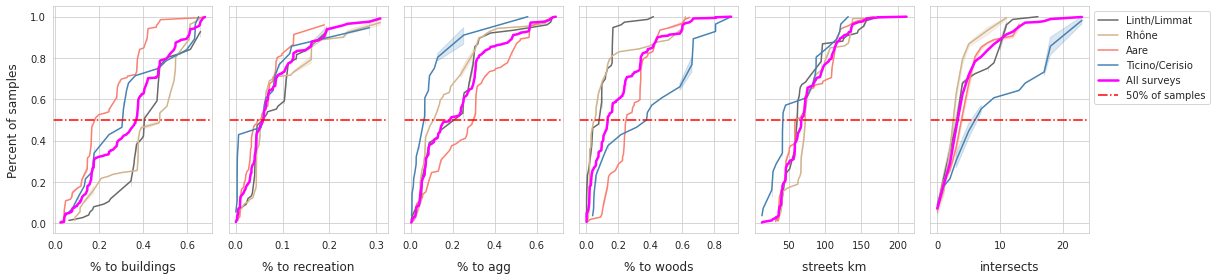

In [4]:
# gather the land use data for each location
luse_this_study = dfBeaches.loc[fd_locs].copy()
sns.set_style('whitegrid')

# the locations in the area of walensee are missing luse dataf
# we are only comparing locations that have a complete profile
lu_th_st = luse_this_study[luse_this_study.luse_total > 650]

# the data minus the locations with incomplete land use data
grtr_10 = fd[fd.location.isin(lu_th_st.index)].copy()
dt_nw = grtr_10.groupby(use_these_cols[:-2], as_index=False).agg({'p/50m':'sum'})

# the cumulative distributions for the different survey areas
ecdfs = {x:{} for x in comps}
ecdfs.update({"All surveys":{}})

fig, axs = plt.subplots(1,len(luse_exp), figsize=(17,4), sharey=True)

for i, n in enumerate(luse_exp):
    for element in comps:
        ax=axs[i]
        the_data = ECDF(dt_nw[dt_nw.river_bassin == element][n].values)
        ecdfs[element].update({n:the_data})
        
        x, y = the_data.x, the_data.y   

        sns.lineplot(x=x, y=y, ax=ax, label=comp_labels[element], color=comp_palette[comp_labels[element]])
    
    a_all_surveys =  ECDF(dt_nw[n].values)
    ecdfs["All surveys"].update({n:a_all_surveys})
    
    x, y = a_all_surveys.x, a_all_surveys.y
    sns.lineplot(x=x, y=y, ax=ax, label="All surveys", color="magenta", linewidth=2.5)
    ax.axhline(y=.5, linestyle="-.", color="red", label="50% of samples")
    
    if i == 0:
        ax.set_ylabel("Percent of samples", **ck.xlab_k)
    else:
        pass   
      
    ax.set_xlabel(n, **ck.xlab_k)
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
plt.legend(handles, labels, bbox_to_anchor=(1,1))       
plt.tight_layout()
plt.show()  

The survey locations in the Rhône survey area (RSA) and Linth/Limmat survey area (LSA) had the greatest median amount of land attributed to buildings, 47% and 40% respectively and the least amount attributed to woods, 5% and 8%. The Aare survey area (ASA) had the lowest median amount of land attributed to buildings, 16% and the greatest amount of land attributed to aggriculture, 30%. The amount of land attributed to recreation represents sports fields, public beaches and other public gathering places. When compared to the allocation rates of other attributes this value is comparable between the survey areas.

## The key indicators with respect to land use class and code group

In [5]:
# summary stats table
# labels for the .describe function
change_names = {'count':'# samples',
                'mean':'average p/50m',
                'std':'standard deviation',
                'min p/50m':'min',
                '25%':'25%', 
                '50%':'50%',
                '75%':'75%',
                'max':'max p/50',
                'min':'min p/50',
                'total objects':'total objects',
                '# locations':'# locations',
                'survey year':'survey year'
               }

def anew_dict(x):
    new_dict = {}
    for param in x.index:
        new_dict.update({change_names[param]:x[param]})
    return new_dict  

# the most abundant
most_abundant = code_totals.sort_values(by="quantity", ascending=False)[:10].index

# found greater than 50% of the time
l_grtr_50 = code_totals[code_totals['fail rate'] >= 50].index

# the most common
most_common = list(set([*most_abundant, *l_grtr_50]))


# eleminate surveys less than 10m and greater than 100m
# restricts surveys to locations on lakes
grtr_10 = grtr_10[(grtr_10.water == 'l')].copy()

# add different date identifiers
grtr_10['month'] = grtr_10.date.dt.month
# grtr_10['year'] = grtr_10.date.dt.year
# grtr_10['mo_year'] = list(zip(grtr_10['month'], grtr_10['year']))
grtr_10["eom"] = grtr_10.date.map(lambda x: pd.Period(x,freq='M').end_time.date())

def add_pctile_rate(x,ecdfs,feature):
    data = ecdfs['All surveys'][feature](x)
    return np.round((data*100),1)
  

# get the percentile ranking of the land use features for each location
grtr_10['b_group'] = grtr_10["% to buildings"].map(lambda x: add_pctile_rate(x,ecdfs,"% to buildings"))
grtr_10['a_group'] = grtr_10["% to agg"].map(lambda x: add_pctile_rate(x,ecdfs,"% to agg"))
grtr_10['w_group'] = grtr_10["% to woods"].map(lambda x: add_pctile_rate(x,ecdfs,"% to woods"))
grtr_10['r_group'] = grtr_10["% to recreation"].map(lambda x: add_pctile_rate(x,ecdfs,"% to recreation"))

# group all the land use % into called profile
# this is a unique identifier for each location
grtr_10['profile'] = list(zip(grtr_10["% to buildings"], grtr_10["% to agg"], grtr_10["% to woods"], grtr_10["% to recreation"]))

# make a list of the objects by their association to buildings, streets recreation and thier use
# food and drink
cont = ["G27", "G30", "G178", "G200"]

# objects with no or few associations and not related to tobacco or food
dist = list(set(most_common) - set(cont))

# lables for the two groups and a label to catch all the other objects
grtr_10['cont'] = 'part'
grtr_10['cont'] = grtr_10.cont.where(~grtr_10.code.isin(dist), 'dist')
grtr_10['cont'] = grtr_10.cont.where(~grtr_10.code.isin(cont), 'cont')

# survey totals of all locations with its land use profile
initial = ['loc_date','date','a_group', 'b_group', 'r_group', 'w_group', 'streets', 'intersects']
grtr_10dt=grtr_10.groupby(initial, as_index=False).agg({"p/50m":"sum", "quantity":"sum"})
grtr_10qkey = grtr_10dt[['loc_date', 'quantity']].set_index('loc_date')

# assigning survey totals to the cont and dist survey totals
def wtf(x, grtr_10key):
    return grtr_10key.loc[[x]].values[0][0]

# survey totals of contributed and distributed objects, 
second = ['river_bassin','location','loc_date','date','eom', 'a_group', 'b_group', 'r_group', 'w_group', 'streets', 'intersects','profile','cont']
grtr_10dtc=grtr_10.groupby(second, as_index=False).agg({"p/50m":"sum", "quantity":"sum"})

# adding the survey total of all objects to each record
grtr_10dtc['dt']= grtr_10dtc.loc_date.map(lambda x: wtf(x, grtr_10qkey))

# calculating the % total of contributed and distributed at each survey
grtr_10dtc['pt']= grtr_10dtc.quantity/grtr_10dtc.dt

the_dists = grtr_10dtc[grtr_10dtc.cont == 'dist']
the_conts = grtr_10dtc[grtr_10dtc.cont == 'cont']

# get the significance level for both groups
the_dists_m = the_dists['p/50m'].quantile(.6)
the_conts_m = the_conts['p/50m'].quantile(.6)

# establish the significance of each record:
grtr_10dtc['sig'] = False
grtr_10dtc.loc[grtr_10dtc.cont == 'dist', 'sig'] = grtr_10dtc.sig.where( grtr_10dtc['p/50m'] < the_dists_m, True)
grtr_10dtc.loc[grtr_10dtc.cont == 'cont', 'sig'] = grtr_10dtc.sig.where( grtr_10dtc['p/50m'] < the_conts_m, True)

grtr_10dtc['rural'] = ((grtr_10dtc.w_group > 50) | (grtr_10dtc.a_group > 50) ) & (grtr_10dtc.b_group < 50)

less_than = grtr_10dtc[(grtr_10dtc['rural'] == True)].location.unique()
grt_than = grtr_10dtc[(grtr_10dtc['rural'] == False)].location.unique()

# grtr_10allp wallensee locations were removed from the data for land use calculations
# the data was not available, the status of walensee locations will be determined by the
# comparing the population and the survey results of walensee locations against those
# that meet the final criteria

# add columns for all survey values
# grtr_10allp['cont'] = 'part'
# grtr_10allp['cont'] = grtr_10allp.cont.where(~grtr_10allp.code.isin(dist), 'dist')
# grtr_10allp['cont'] = grtr_10allp.cont.where(~grtr_10allp.code.isin(cont), 'cont')

### Assessing composition

The ratio of distributed objects to contributed objects in the rural group was 1.7, in the urban group it was 0.81. On a per survey basis, distributed objects were a greater percent of the total in all surveys from rural locations. In urban locations the ratio of distributed to contributed is the inverse of the rural locations and for approximately 20% of the surveys in urban locations the ratio of distributed to contributed is very close to 1.  

> Sample results from rural locations had a greater portion of trash attributed to fragmented plastics, construction plastics and foams.

In [6]:
dists = grtr_10dtc[(grtr_10dtc.cont == 'dist')][['loc_date', 'location', 'p/50m']].set_index('loc_date')
conts = grtr_10dtc[(grtr_10dtc.cont == 'cont')][['loc_date', 'p/50m']].set_index('loc_date')
conts.rename(columns={"p/50m":"cont"}, inplace=True)
dists.rename(columns={"p/50m":"dist"}, inplace=True)
c_v_d = pd.concat([dists, conts], axis=1)
c_v_d['dt'] = c_v_d.dist/c_v_d.cont
ratio_of_d_c_agg = c_v_d[c_v_d.location.isin(less_than)].dist.sum()/c_v_d[c_v_d.location.isin(less_than)].cont.sum()
ratio_of_d_c_urb= c_v_d[c_v_d.location.isin(grt_than)].dist.sum()/c_v_d[c_v_d.location.isin(grt_than)].cont.sum()
# print(ratio_of_d_c_agg, ratio_of_d_c_urb)

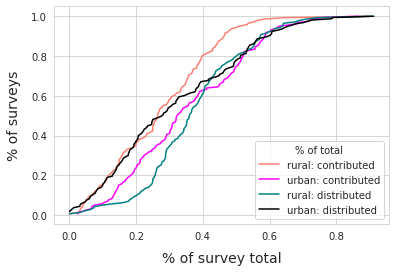

In [7]:
fig, ax = plt.subplots()

co_agecdf = ECDF(grtr_10dtc[(grtr_10dtc.location.isin(grt_than))&(grtr_10dtc.cont.isin(['cont']))]["pt"])
di_agecdf = ECDF(grtr_10dtc[(grtr_10dtc.location.isin(grt_than))&(grtr_10dtc.cont.isin(['dist']))]["pt"])

cont_ecdf = ECDF(grtr_10dtc[(grtr_10dtc.location.isin(less_than))&(grtr_10dtc.cont.isin(['cont']))]["pt"])
dist_ecdf = ECDF(grtr_10dtc[(grtr_10dtc.location.isin(less_than))&(grtr_10dtc.cont.isin(['dist']))]["pt"])

sns.lineplot(x=cont_ecdf.x, y=cont_ecdf.y, color='salmon', label="rural: contributed", ax=ax)
sns.lineplot(x=co_agecdf.x, y=co_agecdf.y, color='magenta', ax=ax, label="urban: contributed")
sns.lineplot(x=dist_ecdf.x, y=dist_ecdf.y, color='teal', label="rural: distributed", ax=ax)
sns.lineplot(x=di_agecdf.x, y=di_agecdf.y, color='black', label="urban: distributed", ax=ax)

ax.set_xlabel("% of survey total", **ck.xlab_k14)
ax.set_ylabel("% of surveys", **ck.xlab_k14)
plt.legend(loc='lower right', title="% of total")

plt.show()

*Difference in composition of rural and urban litter surveys*

*Samples with a higher percentage of distributed objects and lower percentage of contributed objects were more likely in rural environments*

### Survey totals with respect to land use

#### *__Urban - rural:__ survey totals summary data*

The average and median survey results were higher in the urban class, but the maximum and minimum values were recorded in the rural class.

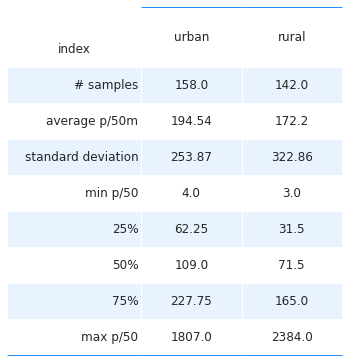

In [8]:
a = grtr_10dtc[(grtr_10dtc.location.isin(less_than))].groupby(['loc_date'])['p/50m'].sum()
b = grtr_10dtc[(grtr_10dtc.location.isin(grt_than))].groupby(['loc_date'])['p/50m'].sum()

l = a.describe().round(2)
m = b.describe().round(2)

# format the data for the table
cl = pd.Series(anew_dict(l), name='rural')
cm = pd.Series(anew_dict(m), name='urban')

data = pd.concat([cm, cl], axis=1)
data.reset_index(inplace=True)
fig, axs = plt.subplots(figsize=(6,6.4))

ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data.values,  colLabels=list(data.columns), colWidths=[.4, .3, .3], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data.values,list(data.columns), a_color)

plt.show()
plt.tight_layout()
plt.close()

### Common objects with respect to land use

#### *__Urban-Rural:__ median p/50m of distributed objects*

The median survey result for disributed objects is very similar under the two land use classes.

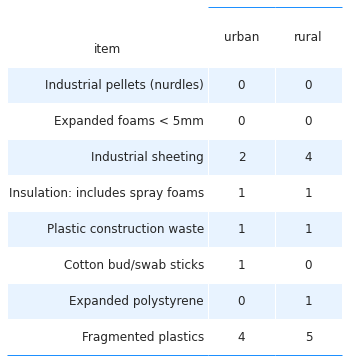

In [9]:
a = grtr_10[(grtr_10.location.isin(grt_than))&(grtr_10.code.isin(dist))].groupby(['loc_date', 'code'], as_index=False)['p/50m'].sum()
a = a.groupby('code').median()
a['item'] = a.index.map(lambda x: code_description_map[x])
a.rename(columns={'p/50m':'urban'}, inplace=True)
a.set_index('item', drop=True, inplace=True)
a=a.astype('int')

b = grtr_10[(grtr_10.location.isin(less_than))&(grtr_10.code.isin(dist))].groupby(['loc_date', 'code'], as_index=False)['p/50m'].sum()
b = b.groupby('code').median()
b['item'] = b.index.map(lambda x: code_description_map[x])
b.rename(columns={'p/50m':'rural'}, inplace=True)
b.set_index('item', drop=True, inplace=True)

c = grtr_10[(grtr_10.location.isin(grt_than))&(grtr_10.code.isin(cont))].groupby(['loc_date', 'code'], as_index=False)['p/50m'].sum()
c = c.groupby('code').median()
c['item'] = c.index.map(lambda x: code_description_map[x])
c.rename(columns={'p/50m':'urban'}, inplace=True)
c.set_index('item', drop=True, inplace=True)
c=c.astype('int')

d = grtr_10[(grtr_10.location.isin(less_than))&(grtr_10.code.isin(cont))].groupby(['loc_date', 'code'], as_index=False)['p/50m'].sum()
d = d.groupby('code').median()
d['item'] = d.index.map(lambda x: code_description_map[x])
d.rename(columns={'p/50m':'rural'}, inplace=True)
d.set_index('item', drop=True, inplace=True)

data_dist = pd.concat([a,b], axis=1)
data_dist.reset_index(inplace=True)

data_cont = pd.concat([c,d], axis=1)
data_cont.reset_index(inplace=True)

fig, axs = plt.subplots(figsize=(6,6.4))

ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data_dist.values,  colLabels=list(data_dist.columns), colWidths=[.6, .2, .2], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data.values,list(data.columns), a_color)

plt.show()
plt.tight_layout()
plt.close()

#### *__Urban-Rural:__ median p/50m of contributed objects*

In contrast to the distributed group, contributed group items all have a higher median survey total under the urban class.

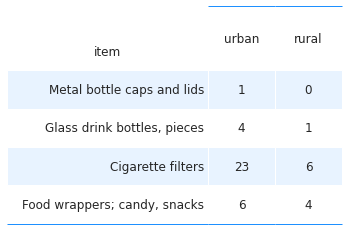

In [10]:
fig, axs = plt.subplots(figsize=(6,4))

ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data_cont.values,  colLabels=list(data_cont.columns), colWidths=[.6, .2, .2], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data_cont.values,list(data_cont.columns), a_color)

plt.show()
plt.tight_layout()
plt.close()


### Seasonal variations

Seasonal variations of beach litter suvey results has been documented under many conditions and many environments. In 2018 the SLR reported the maximum value in July and the minimum in November. The year 2020-2021 presents the same results.

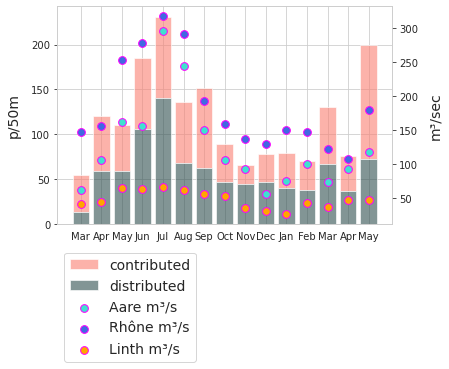

In [11]:
# the survey results to test
corr_data = grtr_10[(grtr_10.code.isin(most_common))].copy()
results_sprmns = {}
for i,code in enumerate(most_common):
    data = corr_data[corr_data.code == code]
    for j, n in enumerate(luse_exp):
        corr, a_p = stats.spearmanr(data[n], data[unit_label])
        results_sprmns.update({code:{"rho":corr, 'p':a_p}})

# helper dict for converting ints to months
months={
    0:'Jan',
    1:'Feb',
    2:'Mar',
    3:'Apr',
    4:'May',
    5:'Jun',
    6:'Jul',
    7:'Aug',
    8:'Sep',
    9:'Oct',
    10:'Nov',
    11:'Dec'
}

m_dt = grtr_10.groupby(['loc_date', 'date','cont'], as_index=False).agg({'quantity':'sum', 'p/50m':'sum'})

# sample totals all objects
m_dt_t = grtr_10.groupby(['loc_date','date','month', 'eom'], as_index=False).agg({'p/50m':'sum'})
m_dt_t.set_index('date', inplace=True)

# data montlhy median survey results contributed, distributed and survey total
fxi=m_dt.set_index('date', drop=True)
data1 = fxi[fxi.cont == 'cont']["p/50m"].resample("M").mean()
data2 = fxi[fxi.cont == 'dist']["p/50m"].resample("M").mean()
# data3 = m_dt_t['p/50m'].resample("M").mean()

# helper tool for months in integer order
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month


# the monthly average discharge rate of the three rivers where the majority of the samples are
aare_schonau = [61.9, 53, 61.5, 105, 161, 155, 295, 244, 150, 106, 93, 55.2, 74.6, 100, 73.6, 92.1]
rhone_scex =   [152, 144, 146, 155, 253, 277, 317, 291, 193, 158, 137, 129, 150, 146, 121, 107]
linth_weesen = [25.3, 50.7, 40.3, 44.3, 64.5, 63.2, 66.2, 61.5, 55.9, 52.5, 35.2, 30.5, 26.1, 42.0, 36.9]

fig, ax = plt.subplots()
    
this_x = [i for i,x in  enumerate(data1.index)]
this_month = [x.month for i,x in enumerate(data1.index)]

twin_ax = ax.twinx()
twin_ax.grid(None)

ax.bar(this_x, data1.to_numpy(), label='contributed', bottom=data2.to_numpy(), linewidth=1, color="salmon", alpha=0.6)
ax.bar([i for i,x in  enumerate(data2.index)], data2.to_numpy(), label='distributed', linewidth=1,color="darkslategray", alpha=0.6)

sns.scatterplot(x=this_x,y=[*aare_schonau[2:], np.mean(aare_schonau)], color='turquoise',  edgecolor='magenta', linewidth=1, s=60, label='Aare m³/s', ax=twin_ax)
sns.scatterplot(x=this_x,y=[*rhone_scex[2:], np.mean(rhone_scex)], color='royalblue',  edgecolor='magenta', linewidth=1, s=60, label='Rhône m³/s', ax=twin_ax)
sns.scatterplot(x=this_x,y=[*linth_weesen[2:], np.mean(linth_weesen), np.mean(linth_weesen)], color='orange', edgecolor='magenta', linewidth=1, s=60, label='Linth m³/s', ax=twin_ax)
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = twin_ax.get_legend_handles_labels()
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

ax.set_ylabel("p/50m", **ck.xlab_k14)
twin_ax.set_ylabel("m³/sec", **ck.xlab_k14)

axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]

plt.xticks(ticks=axisticks, labels=labelsx)
plt.legend([*handles, *handles2], [*labels, *labels2], bbox_to_anchor=(0,-.1), loc='upper left', fontsize=14)

plt.show()

*monthly survey results and river discharge rates m³/second*

*April and May 2021 are rolling averages, data not available*

*source : https://www.hydrodaten.admin.ch/en/stations-and-data.html?entrance_medium=menu*

### The survey results with respect to object group and location group.

The survey results of the distributed group objects are very similar under both land use classes, there is more variance as the reported value increases but not so much that the distributions diverge. Given the standard deviation of the samples and the high variance of beach-litter-survey data in general this is expected. {cite}`eubaselines`

The two sample Kolmogorov-Smirnov(KS) test(ks=0.073, p=0.808) of the two sets of survey results suggest that **the survey results of distributed objects may not be significantly diffrent between the two land use classes**. The results from the Mann-Whitney *U* (MWU) (U=11445.0, p=0.762) **suggeest that it is possible that the two distributions are the same.**.{cite}`ks2sample` {cite}`mannwhitney`

*Rural - Urban empirical cumulative distribution of survey results*

*left: distributed , right: contributed*

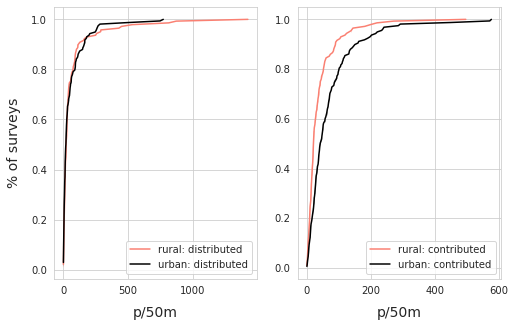

In [12]:
dist_results_agg = grtr_10dtc[(grtr_10dtc.location.isin(less_than))&(grtr_10dtc.cont == 'dist')].groupby(['loc_date', 'cont'])['p/50m'].sum().values
dist_results_urb = grtr_10dtc[(grtr_10dtc.location.isin(grt_than))&(grtr_10dtc.cont == 'dist')].groupby(['loc_date', 'cont'])['p/50m'].sum().values
a_d_ecdf = ECDF(dist_results_agg )
b_d_ecdf = ECDF(dist_results_urb )

# print(len(a_d_ecdf.x))
# print(len(b_d_ecdf.x))
# print(a_d_ecdf(85), b_d_ecdf(85))

cont_results_agg = grtr_10dtc[(grtr_10dtc.location.isin(less_than))&(grtr_10dtc.cont == 'cont')].groupby('loc_date')['p/50m'].sum().values
cont_results_urb = grtr_10dtc[(grtr_10dtc.location.isin(grt_than))&(grtr_10dtc.cont == 'cont')].groupby('loc_date')['p/50m'].sum().values
a_d_ecdf_cont = ECDF(cont_results_agg)
b_d_ecdf_cont = ECDF(cont_results_urb)

fig, ax = plt.subplots(1,2, figsize=(8,5))

axone = ax[0]
sns.lineplot(x=a_d_ecdf.x, y=a_d_ecdf.y, color='salmon', label="rural: distributed", ax=axone)
sns.lineplot(x=b_d_ecdf.x, y=b_d_ecdf.y, color='black', label="urban: distributed", ax=axone)
axone.set_xlabel('p/50m', **ck.xlab_k14)
axone.set_ylabel('% of surveys', **ck.xlab_k14)


axtwo = ax[1]
sns.lineplot(x=a_d_ecdf_cont.x, y=a_d_ecdf_cont.y, color='salmon', label="rural: contributed", ax=axtwo)
sns.lineplot(x=b_d_ecdf_cont.x, y=b_d_ecdf_cont.y, color='black', label="urban: contributed", ax=axtwo)

axtwo.set_xlabel('p/50m', **ck.xlab_k14)
axtwo.set_ylabel(' ')

plt.show()

On the other hand the contributed objects survey results diverge almost immediately according to rural or urban class. This is also expected if the test for association was correct, the rural locations have less buildings and more aggriculture or woods. The two conditions together should reduce the amount of tobacco and food wrappers for that class. 

The KS and MWU tests both agree with the visual results that rural and urban survey results for **contributed objects most likely come from different distributions and they are not equal** (ks=0.284, pvalue<.0001), (U=7559.0, pvalue<.0001).

#### Distributed objects: difference of means  rural - urban 

*Difference of means rural - urban, method=shuffle, permutations=5000*

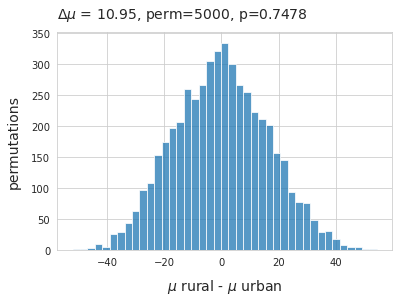

In [13]:
# pemutation test: of difference of means HD objects
agg_dobj = grtr_10[(grtr_10.location.isin(less_than))&(grtr_10.cont == 'dist')].groupby(['loc_date'], as_index=False)['p/50m'].sum()
buld_obj = grtr_10[(grtr_10.location.isin(grt_than))&(grtr_10.cont == 'dist')].groupby(['loc_date'], as_index=False)['p/50m'].sum()
# label the urban and rural results
agg_dobj['class'] = 'rural'
buld_obj['class'] = 'urban'

# merge into one 
objs_merged = agg_dobj.append(buld_obj)

# store the mean per class
the_mean = objs_merged.groupby('class')['p/50m'].mean()

# store the difference
mean_diff = the_mean.loc['rural'] - the_mean.loc['urban']
new_means=[]
# permutation resampling:
for element in np.arange(5000):
    objs_merged['new_class'] = objs_merged['class'].sample(frac=1).values
    b=objs_merged.groupby('new_class').mean()
    new_means.append((b.loc['rural'] - b.loc['urban']).values[0])
emp_p = np.count_nonzero(new_means <= (the_mean.loc['rural'] - the_mean.loc['urban'])) / 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(mean_diff, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel('permutations', **ck.xlab_k14)
ax.set_xlabel("$\mu$ rural - $\mu$ urban", **ck.xlab_k14)
plt.show()

*There is no statistical reason to reject the null hypothesis that these two distributions may be the same*

In [14]:
# stats.ks_2samp(dist_results_agg, dist_results_urb, alternative='two-sided', mode='auto')
# stats.mannwhitneyu(dist_results_agg,dist_results_urb, alternative='two-sided')

In [15]:
# the results for contributed objects
# stats.ks_2samp(cont_results_agg, cont_results_urb, alternative='two-sided', mode='auto')
# stats.mannwhitneyu(cont_results_agg, cont_results_urb, alternative='two-sided')

### The survey results of FP and FD with respect to land use

__Results of KS test and Mann Whitney U__

The survey results for FP objects is very similar up to the 65th percentile where the rural survey results are noticeably larger. According to the KS test (ks=0.092, pvalue=0.50) and MWU test (U=11592.0, pvalue=0.62) the distribution of FP objects under the two land use classes is not significantly different and may be equal. 

The survey results for FD objects maintain the same features as the parent distribution. The results of the KS test (ks=0.29, pvalue<.001) and MWU test (U=7647.5, p<.001) agree with the results of the parent group, that there is a statisically relevant difference between the survey results under different land use classes.

*Left rural - urban: empirical cumulative distribution of survey results fragmented and construction plastics*

*Right rural - urban: empirical cumulative distribution of survey results cigarette ends and candy wrappers*

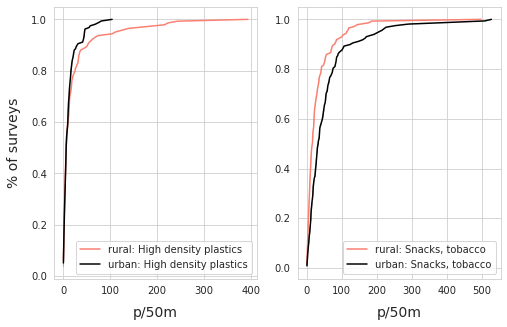

In [16]:
agg_dobj = grtr_10[(grtr_10.location.isin(less_than))&(grtr_10.code.isin(['Gfrags', 'G89']))].groupby(['loc_date'])['p/50m'].sum().values
buld_obj = grtr_10[(grtr_10.location.isin(grt_than))&(grtr_10.code.isin(['Gfrags', 'G89']))].groupby(['loc_date'])['p/50m'].sum().values

a_d_ecdf = ECDF(agg_dobj)
b_d_ecdf = ECDF(buld_obj)

# print(len(a_d_ecdf.x))
# print(len(b_d_ecdf.x))
# print(a_d_ecdf(17), b_d_ecdf(15))
# print(np.quantile(a_d_ecdf.x,.65))
# print(np.quantile(b_d_ecdf.x, .65))

agg_cont = grtr_10[(grtr_10.location.isin(less_than))&(grtr_10.code.isin(['G27', 'G30']))].groupby(['loc_date'])['p/50m'].sum().values
b_cont = grtr_10[(grtr_10.location.isin(grt_than))&(grtr_10.code.isin(['G27', 'G30']))].groupby(['loc_date'])['p/50m'].sum().values

a_c_ecdf = ECDF(agg_cont)
b_c_ecdf = ECDF(b_cont)

fig, ax = plt.subplots(1,2, figsize=(8,5))

axone = ax[0]
sns.lineplot(x=a_d_ecdf.x, y=a_d_ecdf.y, color='salmon', label="rural: High density plastics", ax=axone)
sns.lineplot(x=b_d_ecdf.x, y=b_d_ecdf.y, color='black', label="urban: High density plastics", ax=axone)
axone.set_xlabel('p/50m', **ck.xlab_k14)
axone.set_ylabel('% of surveys', **ck.xlab_k14)


axtwo = ax[1]
sns.lineplot(x=a_c_ecdf.x, y=a_c_ecdf.y, color='salmon', label="rural: Snacks, tobacco", ax=axtwo)
sns.lineplot(x=b_c_ecdf.x, y=b_c_ecdf.y, color='black', label="urban: Snacks, tobacco", ax=axtwo)

axtwo.set_xlabel('p/50m', **ck.xlab_k14)
axtwo.set_ylabel(' ')

plt.show()

In [17]:
# print(stats.ks_2samp(agg_cont , b_cont,  alternative='two-sided', mode='auto'))
# print(stats.mannwhitneyu(agg_cont , b_cont, alternative='two-sided'))

#### FP and FD: difference of means

The average survey result of FP objects in rural locations was 22.93p/50m in urban locations it was 12p/50m. A permutation test on the difference of means was conducted on the condition *rural* / *urban*. The results from each group were labled and then the labels were shuffled randomly and the average of the two groups was calculated and the difference between the two recorded. 

##### fragmented plastics and plastic construction waste: difference of means rural-urban

*Difference of means rural - urban, method=shuffle, permutations=5000*

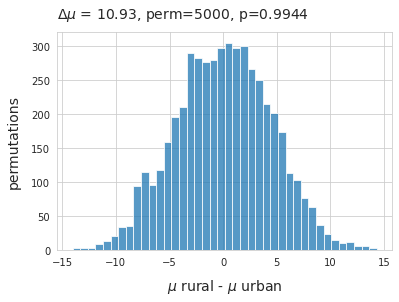

In [18]:
# pemutation test: of difference of means HD objects
agg_dobj = grtr_10[(grtr_10.location.isin(less_than))&(grtr_10.code.isin(['Gfrags', 'G89']))].groupby(['loc_date'], as_index=False)['p/50m'].sum()
buld_obj = grtr_10[(grtr_10.location.isin(grt_than))&(grtr_10.code.isin(['Gfrags', 'G89']))].groupby(['loc_date'], as_index=False)['p/50m'].sum()
# label the urban and rural results
agg_dobj['class'] = 'rural'
buld_obj['class'] = 'urban'

# merge into one 
objs_merged = agg_dobj.append(buld_obj)

# store the mean per class
the_mean = objs_merged.groupby('class')['p/50m'].mean()

# store the difference
mean_diff = the_mean.loc['rural'] - the_mean.loc['urban']
new_means=[]
# permutation resampling:
for element in np.arange(5000):
    objs_merged['new_class'] = objs_merged['class'].sample(frac=1).values
    b=objs_merged.groupby('new_class').mean()
    new_means.append((b.loc['rural'] - b.loc['urban']).values[0])
emp_p = np.count_nonzero(new_means <= (the_mean.loc['rural'] - the_mean.loc['urban'])) / 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(mean_diff, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel('permutations', **ck.xlab_k14)
ax.set_xlabel("$\mu$ rural - $\mu$ urban", **ck.xlab_k14)
plt.show()

The observed test statistic is very close to the upper limit but still not significant at the 5% level.

The same test was conducted on the FD objects

##### cigarette ends and snack wrappers: difference of means rural-urban

*Difference of means rural - urban, method=shuffle, permutations=5000*

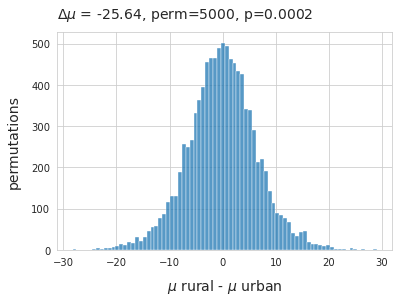

In [19]:
# pemutation test: of difference of means food objects
agg_cont = grtr_10[(grtr_10.location.isin(less_than))&(grtr_10.code.isin(['G27', 'G30']))].groupby(['loc_date'], as_index=False)['p/50m'].sum()
b_cont = grtr_10[(grtr_10.location.isin(grt_than))&(grtr_10.code.isin(['G27', 'G30']))].groupby(['loc_date'], as_index=False)['p/50m'].sum()
# label the urban and rural results
agg_cont['class'] = 'rural'
b_cont['class'] = 'urban'

# merge into one 
objs_merged = agg_cont.append(b_cont)

# store the mean per class
the_mean = objs_merged.groupby('class')['p/50m'].mean()

# store the difference
mean_diff = the_mean.loc['rural'] - the_mean.loc['urban']

# permutation resampling:
for element in np.arange(5000):
    objs_merged['new_class'] = objs_merged['class'].sample(frac=1).values
    b=objs_merged.groupby('new_class').mean()
    new_means.append((b.loc['rural'] - b.loc['urban']).values[0])
emp_p = np.count_nonzero(new_means <= (the_mean.loc['rural'] - the_mean.loc['urban'])) / 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(mean_diff, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel('permutations', **ck.xlab_k14)
ax.set_xlabel("$\mu$ rural - $\mu$ urban", **ck.xlab_k14)
plt.show()

The difference of means is confirmed between the two land use cases.

In [20]:
all_high_density = grtr_10[(grtr_10.code.isin(['Gfrags', 'G89', 'G95']))].groupby(['loc_date', 'location', 'river_bassin', 'intersects', 'water_name_slug'], as_index=False)['p/50m'].sum()
the_80th = all_high_density['p/50m'].quantile(.8)
all_high_density['rural'] = True
all_high_density['rural'] = all_high_density.rural.where(all_high_density.location.isin(less_than)==True, False)

grtr_80 = all_high_density[all_high_density['p/50m'] > the_80th].copy()
summary = grtr_80.groupby(['rural', 'location'], as_index=False).agg({'loc_date':'nunique', 'p/50m':'median' }).sort_values(by=['rural', 'p/50m'], ascending=False)
# grtr_80.groupby('rural').agg({'location':'nunique', 'loc_date':'nunique', 'p/50m':'median'})

In [21]:
these_beaches = dfBeaches.loc[summary.location.unique()]

these_stats = summary[['location', 'p/50m']].set_index('location')
export_these_map_points = pd.concat([these_beaches, these_stats], axis=1)

## Discussion

Lakes are considered buffer zones for plastics in coastal regions. They accumulate plastics from inland sources such as rivers and streams. In the lakes the plastics are transformed/aged, some sink or some are passed on to the ocean. {cite}`liuyan`

In the Great Lakes elevated numbers of plastics can be associated to the high population density near the shoreline, a feature common in Switzerland. A portion of those plastics are denser polymers. Changes due to weathering or colonization by organisms can change an objects density enough that it will change the horzontal distance that the object will travel before (if) it settles. {cite}`cablerachel`

The results of the test show that the distributed objects are found at similar rates regardless of land use class. Suggesting that there is another mechanism of transport and deposition for these objects that is not directly associated with behavior. The presence of high density plastics in this group and the numerous river or canal discharge sites within 1500 meters of every survey location support previous observations that these objects are being transported to the survey site and a portion of them are sinking.

The monthly average of distribution objects changes at the same rythym as contribution objects, but it would be incorrect to assume that the causes are the same. The summer bathing season and peak in outdoor activities coincides with the peak in discharge rates for the three rivers in this study. Seasonality of litter related to food and tobacco consumption is well documented and was noted in the Swiss Litter Report. {cite}`slr` {cite}`araujo` {cite}`meuserhine` 

Indutrial pellets and small foam balls have a 0 median survey result, confirming the *transient* nature of these objects in the survey results. Objects less than 5mm have a decreasing surface-to-mass ratio making them more suceptible to bio-fouling and more likely to sink quicker than larger objects made from similar polymers. However, it was not uncommon to find *industrial pellets* and *small expanded foam balls* mixed in with floating organic material such as algae or grass clippings.

__The similarity of the results indifferent of the land use profile, suggests that distributed group objects are ubiquotous on lake and river shores and they are being deposited at similar rates__. Local maximum and minimum values are to be expected. Distribtution group items are $\approx$ 25% of all items found and they were found in at least 1/2 surveys through out all the survey areas.  Fragmented plstics and construction plastics alone are $\approx$ 15% of all the objects found. The factors that effect the deposition of high density plastics at a survey location:

1. proximity to MAJOR river discharge or drainage
2. number of canals or intersections in proximity
3. local industrial/ecomnomic activity

If direct dumping into the water is excluded as a general method of disposal, then the only common source between rural and urban locations is the river and canal network. Refuse of all types enters the rivers and canals through rain water runoff from streets and sidewalks this is the most likely trasnsport method of high density plastics. The inconclusive associations with number of intersects suggest that the number of rivers is less important than the size of the river intersecting the lake.

Contrary to food or tobacco items, local efforts to reduce HD objects are difficult to assess because of the transport method. Efforts to reduce HD in the water need to be focussed upstream from where the assessement measurements are being taken. This requires a coordinated strategy and monitoring network at the level of the catchment area or river bassin.

In [22]:
author = "roger@hammerdirt.ch"
my_message = "Love what you do. \u2764\ufe0f"
md(F"""
**This project was made possible by the Swiss federal office for the environment.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
""")


**This project was made possible by the Swiss federal office for the environment.**<br>

>Love what you do. ❤️<br>

*roger@hammerdirt.ch* pushed the run button on 2021-08-02.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>


### Annex

1. [surveyors](#us)
2. [municipalities, lakes, rivers](#munislakes)

The average length and survey area for each location was used to replace the missing values for each record.

[annex](#annex)<a id="us"></a>
#### IQAASL surveyors

Hammerdirt staff:

1. Shannon Erismann, field operations manager
2. Helen Kurukulasuriya, surveyor
3. Débora Carmo, surveyor
4. Bettina Siegenthaler, surveyor
5. Roger Erismann, surveyor

Participating organizations:

1. Precious plastic leman
2. Association pour la sauvetage du Léman
3. Geneva international School
4. Solid waste management: École polytechnique fédéral Lausanne

[annex](#annex)<a id="munislakes"></a>
#### Municipalities, lakes and rivers with surveys

In [23]:
lakes = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'l')]['water_name'].unique()
rivers = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'r')]['water_name'].unique()
munis_joined = ', '.join(sorted(fd_pop_map.index))

muni_string = F"""**The municipalities in this report:**\n\n{munis_joined}
"""
md(muni_string)

**The municipalities in this report:**

Aarau, Allaman, Ascona, Beatenberg, Bellinzona, Bern, Biel/Bienne, Boudry, Bourg-en-Lavaux, Brienz (BE), Brissago, Brugg, Brügg, Burgdorf, Bönigen, Cheyres-Châbles, Cudrefin, Dietikon, Erlach, Estavayer, Freienbach, Gals, Gambarogno, Gebenstorf, Genève, Gland, Glarus Nord, Grandson, Hauterive (NE), Hünenberg, Kallnach, Köniz, Küsnacht (ZH), La Tour-de-Peilz, Lausanne, Lavey-Morcles, Le Landeron, Leuk, Ligerz, Locarno, Lugano, Luterbach, Lüscherz, Merenschwand, Minusio, Montreux, Neuchâtel, Nidau, Port, Préverenges, Quarten, Rapperswil-Jona, Richterswil, Riddes, Rubigen, Saint-Gingolph, Saint-Sulpice (VD), Salgesch, Schmerikon, Sion, Solothurn, Spiez, Stäfa, Thun, Tolochenaz, Unterengstringen, Unterseen, Versoix, Vevey, Vinelz, Walenstadt, Walperswil, Weesen, Weggis, Yverdon-les-Bains, Zug, Zürich


In [24]:
lakes_joined = ', '.join(sorted(lakes))

lake_string = F"""**The lakes in this report:**\n\n{lakes_joined}
"""
md(lake_string)

**The lakes in this report:**

Bielersee, Brienzersee, Lac Léman, Lago Maggiore, Lago di Lugano, Neuenburgersee, Quatre Cantons, Thunersee, Walensee, Zugersee, Zurichsee


In [25]:
rivers_joined = ', '.join(sorted(rivers))

river_string = F"""**The rivers in this report:**\n\n{rivers_joined}
"""
md(river_string)

**The rivers in this report:**

Aare, Aare|Nidau-Büren-Kanal, Cassarate, Dorfbach, Emme, Escherkanal, Jona, La Thièle, Limmat, Linthkanal, Maggia, Reuss, Rhône, Schüss, Seez, Sihl, Ticino


In [26]:
obj_string = '{:,}'.format(fd_n_obj)
surv_string = '{:,}'.format(fd_n_samps)
pop_string = '{:,}'.format(int(fd_effected_population[0]))

In [27]:
date_quantity_context = F"For the period between {start_date[:-3]} and {end_date[:-3]}, {obj_string } objects were removed and identified in the course of {surv_string} surveys."
geo_context = F"Those surveys were conducted at {fd_n_locs} different locations."
admin_context = F"There are {fd_n_munis} different municipalities represented in these results with a combined population of approximately {pop_string}."
md(F"{date_quantity_context} {geo_context } {admin_context}")

For the period between 2020-03 and 2021-05, 54,713 objects were removed and identified in the course of 385 surveys. Those surveys were conducted at 143 different locations. There are 77 different municipalities represented in these results with a combined population of approximately 1,735,991.